# エンゼルの出現確率を予測する

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import pymc as pm

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement'):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,weight,box_weight,ball_number,factory,shop,angel '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','weight','box_weight','ball_number','factory','shop','angel', 'net_weight', 'mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data
data = get_data()

Shape of MeasurementData(record_num, n_columns) : (15, 10)


In [6]:
data_angel = data['angel'].values
print 'angel rate(freq):{}'.format(data_angel.mean())

angel rate(freq):0.0


モデル
- データ過程：ベルヌーイ分布（確率pで事象が発生し、(1-p)で発生しない）
- 事前分布：ベータ分布（0~1の実数を取る分布）

,x,y
5,0.05,7.924426
6,0.06,7.777316
4,0.04,7.735043


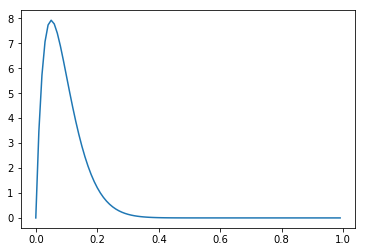

In [27]:
import scipy.stats as stats
x = np.linspace(0.0, 0.99, 100)
y = stats.beta.pdf(x, 2,20)
plt.plot(x, y)
pd.DataFrame({'x':x, 'y':y}).sort_values(by=['y'], ascending=False)[:3]

In [29]:
# 出現確率pの事前分布
p = pm.Beta('p', alpha=2, beta=20)
# 観測を結びつける
obs = pm.Bernoulli('obs', p, value=data_angel, observed=True)

# MCMC
# Modelオブジェクト生成
model = pm.Model([p, obs])
mcmc = pm.MCMC(model)
mcmc.sample(15000, 5000)

 [-----------------100%-----------------] 15000 of 15000 complete in 0.7 sec

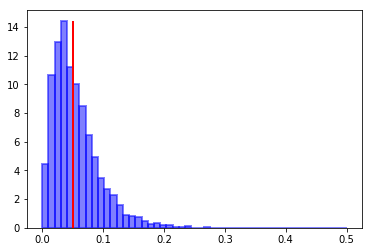

In [40]:
p_trace = mcmc.trace('p')[:]
ret = plt.hist(p_trace, bins=np.linspace(0, 0.5, 50), normed=True, 
               color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
plt.vlines(x=0.05, ymin=0, ymax=ret[0].max(), 
           colors='#FF0000', linewidths=2, label='spec') # 初期分布の最大値

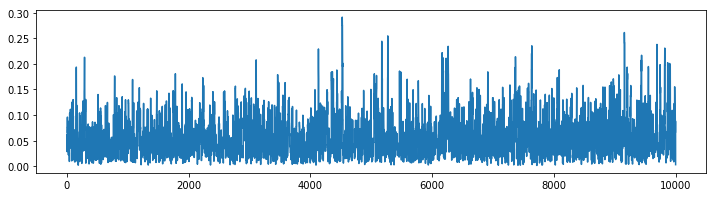

In [41]:
plt.figure(figsize=(12, 3))
plt.plot(p_trace)

事前分布に一様分布を用いたらどうなるか？

In [42]:
# 出現確率pの事前分布
#p = pm.Beta('p', alpha=2, beta=20)
p = pm.Uniform('p', lower=0, upper=1)
# 観測を結びつける
obs = pm.Bernoulli('obs', p, value=data_angel, observed=True)

# MCMC
# Modelオブジェクト生成
model = pm.Model([p, obs])
mcmc = pm.MCMC(model)
mcmc.sample(15000, 5000)

 [-----------------100%-----------------] 15000 of 15000 complete in 0.6 sec

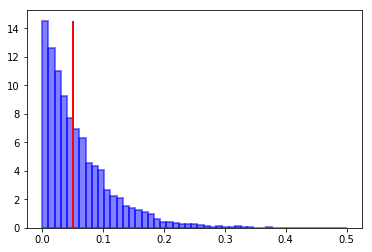

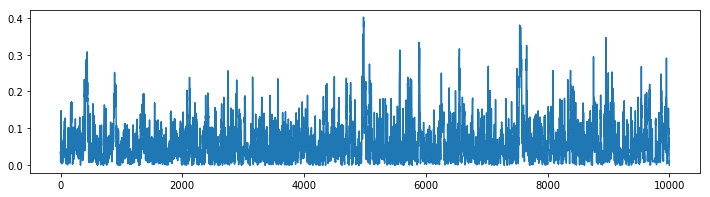

In [43]:
p_trace = mcmc.trace('p')[:]
ret = plt.hist(p_trace, bins=np.linspace(0, 0.5, 50), normed=True, 
               color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
plt.vlines(x=0.05, ymin=0, ymax=ret[0].max(), 
           colors='#FF0000', linewidths=2, label='spec') # 初期分布の最大値

plt.figure(figsize=(12, 3))
plt.plot(p_trace)